## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [43]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn-v0_8')
%matplotlib inline

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [44]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [46]:
data['InvoiceDate'] = data['InvoiceDate'].astype('datetime64[ns]')

Давайте посмотрим описательную статистику для переменных представленных числовым типом.

In [47]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

Теперь посмотрим на статистику категориальных переменнных.

In [48]:
data.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.

Для начала посмотрим сколько припусков в наших данных и сколько процентов они состовляют от каждого признака.

In [49]:
display(data.isnull().mean() * 100)
print(f'Всего пропусков в таблице: {data.isnull().sum().sum()}')

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Всего пропусков в таблице: 136534


Удалим все строки содержащие пропуски.

In [50]:
print(f'Количество наблюдений до удаления пропусков: {data.shape[0]}')
data = data.dropna(axis=0)
print(f'Количество наблюдений после удаления пропусков: {data.shape[0]}')

Количество наблюдений до удаления пропусков: 541909
Количество наблюдений после удаления пропусков: 406829


Следом за пропусками проверим наличие дубликатов.

In [51]:
print(f'Количесвто дубликатов в данных: {data.duplicated().sum()}')
data = data.drop_duplicates()
print(f'Количество наблюдений после удаления дубликатов: {data.shape[0]}')

Количесвто дубликатов в данных: 5225
Количество наблюдений после удаления дубликатов: 401604


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [52]:
negative_quantity = data[(data['Quantity']<0)]
print(f'Count of entries with a negative number: {negative_quantity.shape[0]}')
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

* Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
* Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
* Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.
* Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице)

<strong>Примечание.</strong> При анализе таблицы можно заметить, что отрицательное количество товаров может не сопровождаться признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех них не указан идентификатор пользователя (CustomerID). Мы удалили эти транзакции, когда удаляли строки таблицы, в которых пропущен идентификатор пользователя.

Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [53]:
negative_quantity['is_refund'] = negative_quantity['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
negative_quantity['is_refund'].value_counts()

is_refund
1    8872
Name: count, dtype: int64

Все транзакции с отрицательным количеством товара являются возвратами.

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [54]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [55]:
nb_products_per_basket['is_refund'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
nb_products_per_basket['is_refund'].value_counts(normalize=True) * 100

is_refund
0    83.533123
1    16.466877
Name: proportion, dtype: float64

Давайте поближе взглянем на отмененные заказы:


In [56]:
nb_products_per_basket[nb_products_per_basket['is_refund']==1].head()

,CustomerID,InvoiceNo,Number of products,is_refund
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [57]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена».

Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна

Нет, это не всегда так, посмотрим на пример ниже.

In [58]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 

И эта гипотеза не подтвердилась, посмотрим на пример ниже.

In [59]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Создадим функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [60]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
data['QuantityCanceled'] = quantity_canceled

Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled. 

In [61]:
data['QuantityCanceled'].sum()

245266.0

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.

In [62]:
data = data[data['Quantity'] >= 0]
data.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

In [63]:
display(data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].value_counts())
data = data[~(data['StockCode'].str.contains('^[a-zA-Z]+', regex=True))]
data.shape

StockCode
POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64

(391183, 9)

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких наблюдений немного, поэтому избавимся от них.

In [64]:
data = data[~(data['UnitPrice'] == 0)]
data.shape

(391150, 9)

Сохраним очищенные данные в новый файл.

In [65]:
data.to_csv('./data/clear_data.csv', index=False)

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

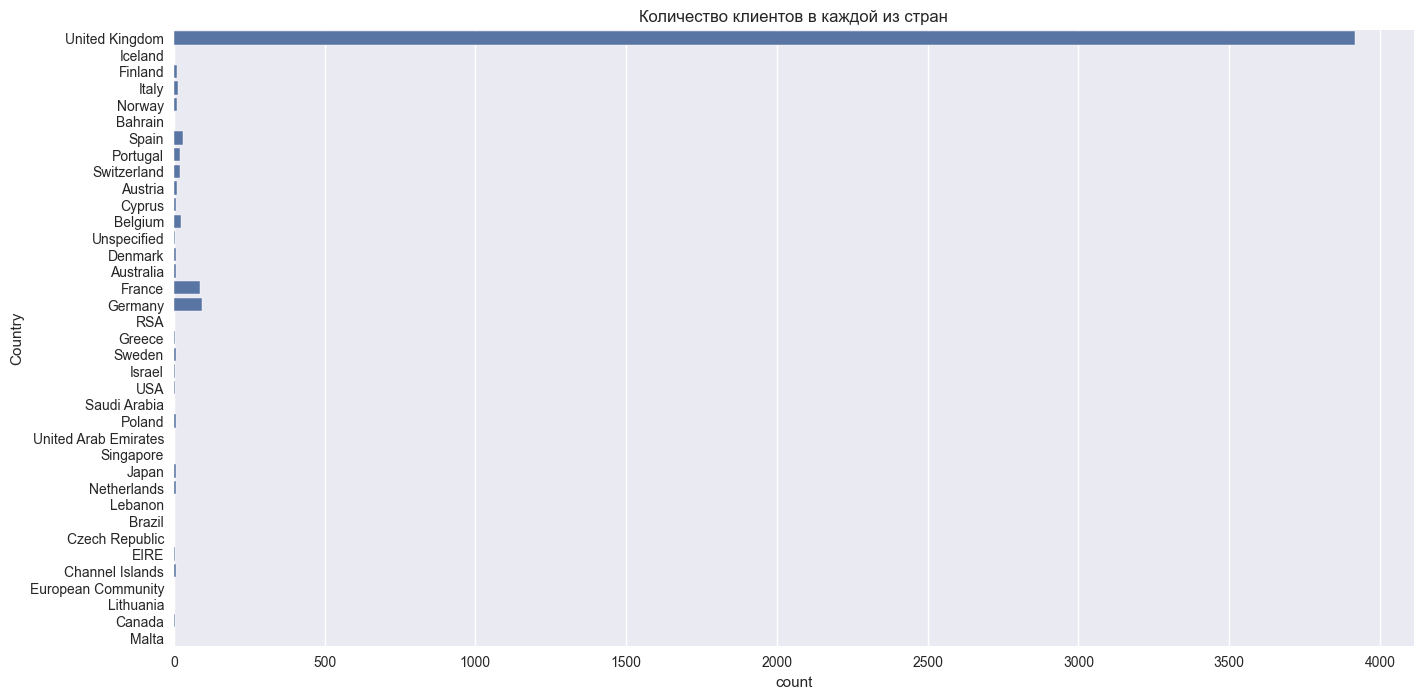

In [66]:
temp = data.groupby(['CustomerID', 'Country'], as_index=False)['InvoiceDate'].count()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(temp, y='Country', ax=ax)
ax.set_title('Количество клиентов в каждой из стран');

Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Построим визуализацию по количеству поступающих заказов.

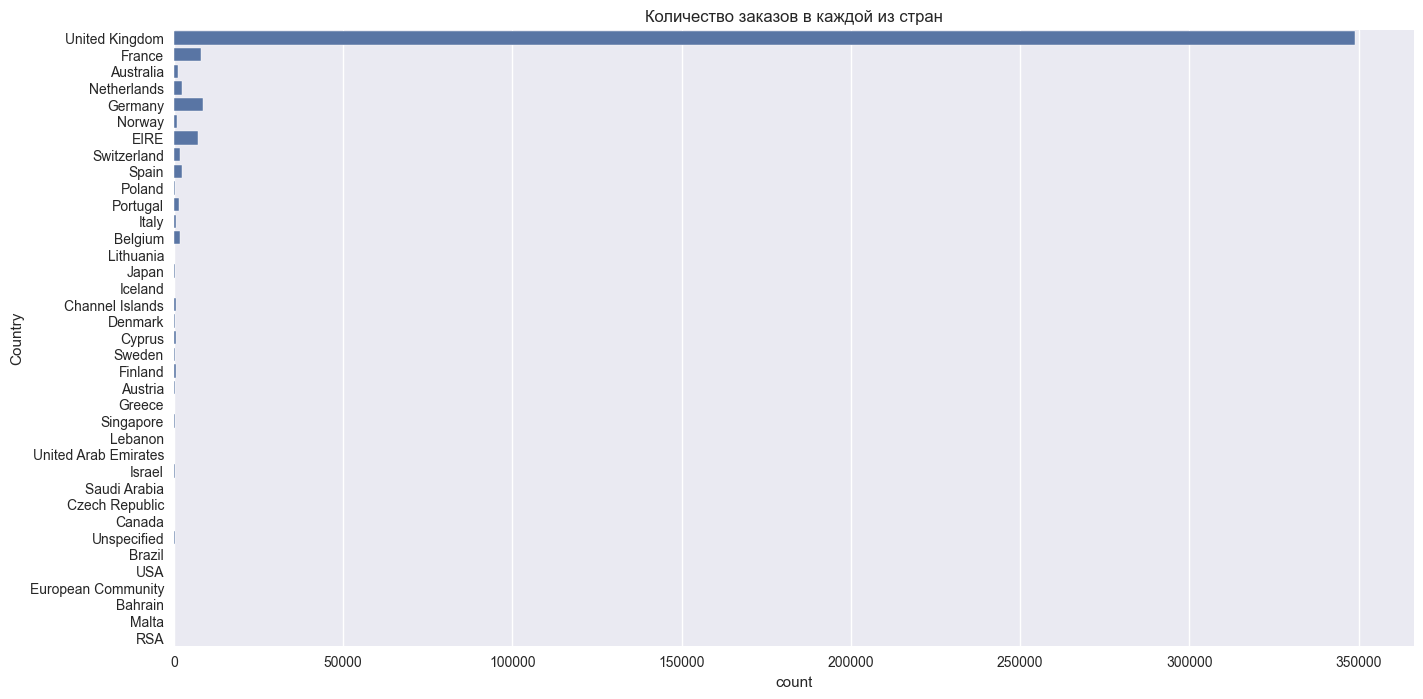

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, y='Country', ax=ax)
ax.set_title('Количество заказов в каждой из стран');

Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [68]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
round(data['TotalPrice'].mean())

21

Построим визуализацию, чтобы узнать страны, клиенты из которых приносят компании больше всего выручки.

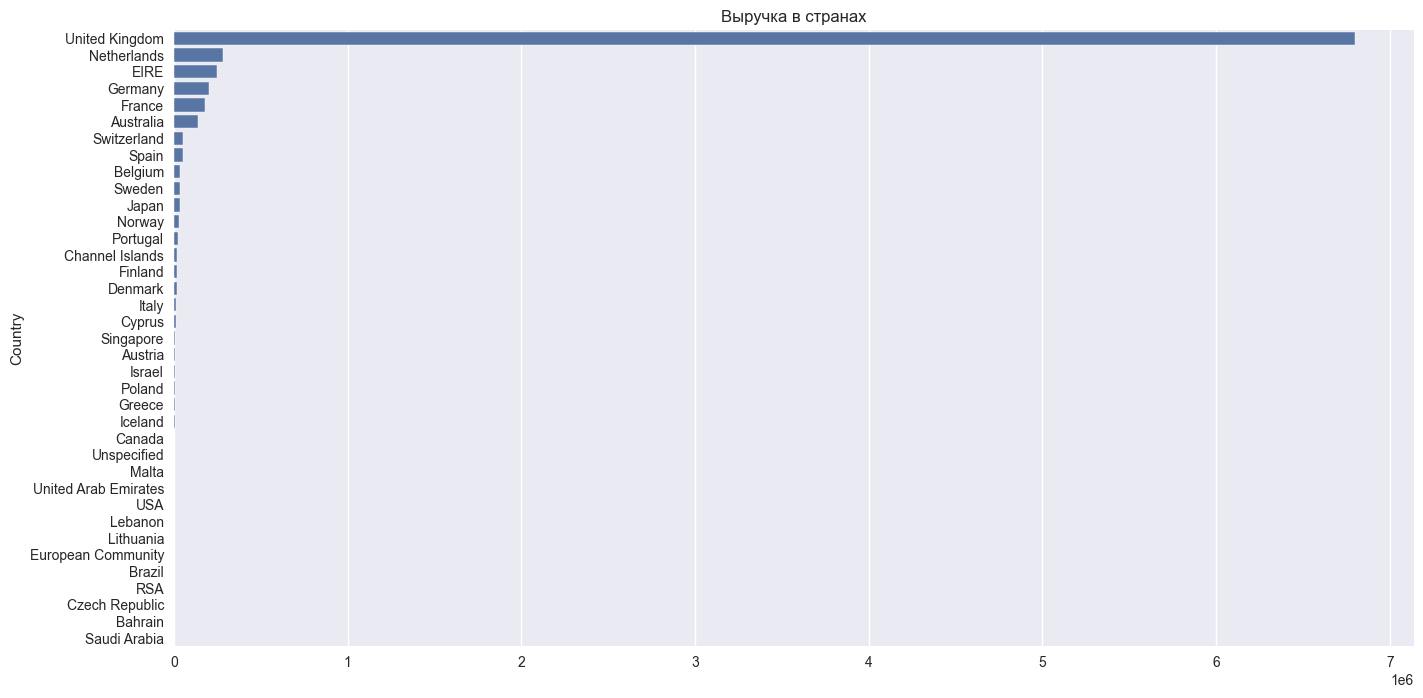

In [69]:
temp = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.barplot(x=temp.values, y=temp.index, ax=ax)
ax.set_title('Выручка в странах');

Теперь займёмся временными характеристиками.


Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

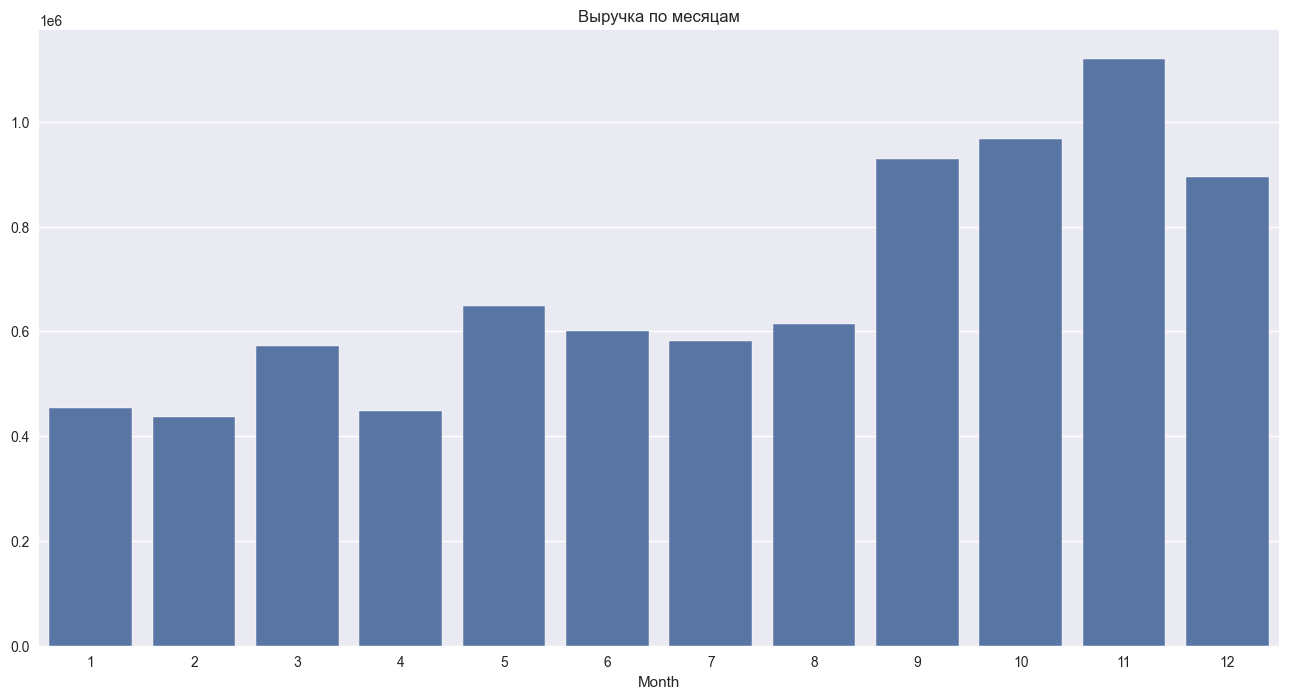

In [70]:
data['Month'] = data['InvoiceDate'].dt.month
data['Day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['Hour'] = data['InvoiceDate'].dt.hour

temp = data.groupby('Month')['TotalPrice'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.barplot(y=temp.values, x=temp.index, ax=ax)
ax.set_title('Выручка по месяцам');

Самый прибыльный месяц - это ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Постройте визуализацию количества заказов для каждого дня недели.

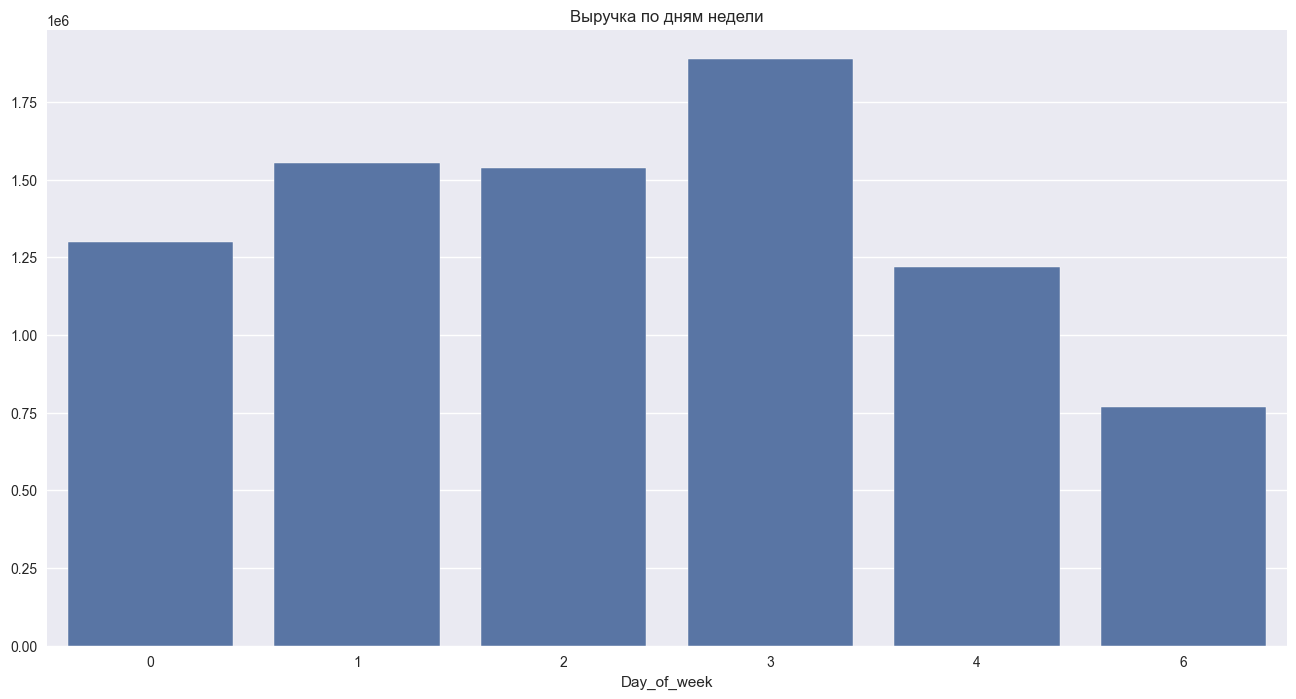

In [71]:
temp = data.groupby('Day_of_week')['TotalPrice'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.barplot(y=temp.values, x=temp.index, ax=ax)
ax.set_title('Выручка по дням недели');

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


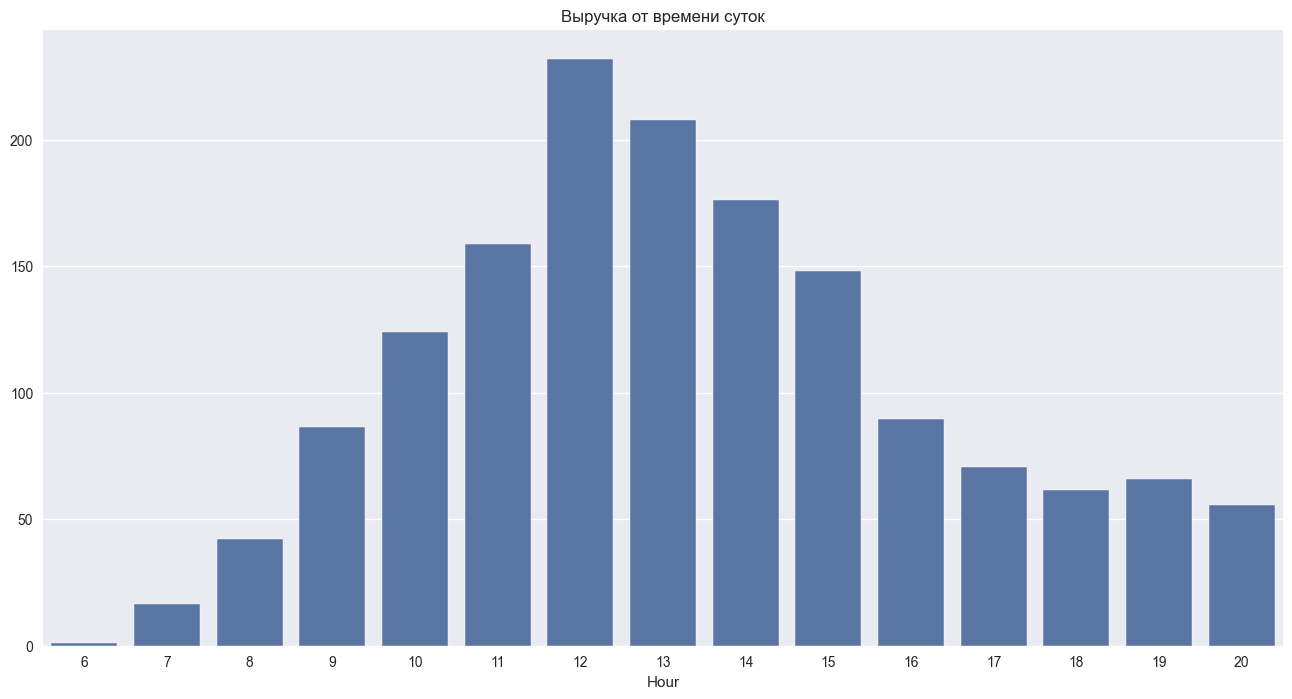

In [72]:
data['Date'] = data['InvoiceDate'].dt.date
temp = data.groupby(['Date', 'Hour'], as_index=False)['TotalPrice'].count()
temp = temp.groupby('Hour')['TotalPrice'].mean()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.barplot(y=temp.values, x=temp.index, ax=ax)
ax.set_title('Выручка от времени суток');

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [73]:
recency_data = data.groupby('CustomerID')['InvoiceDate'].max()
recency_data = (pd.to_datetime('2011-12-10 00:00:00') - recency_data).dt.days
rfm_table = pd.DataFrame(
    data={
        'recency': recency_data,
        'frequency': data.groupby('CustomerID')['InvoiceNo'].nunique(),
        'monetary_value': data.groupby('CustomerID')['TotalPrice'].sum()
    }
)
rfm_table.head()

,recency,frequency,monetary_value
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [74]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

In [75]:
frequency_bound = rfm_table['frequency'].quantile(0.95)
monetary_bound = rfm_table['monetary_value'].quantile(0.95)
mask = (rfm_table['frequency'] <= frequency_bound) & (rfm_table['monetary_value'] <= monetary_bound)

rfm_table_cleaned = rfm_table[mask]
rfm_table.shape

(4334, 3)

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


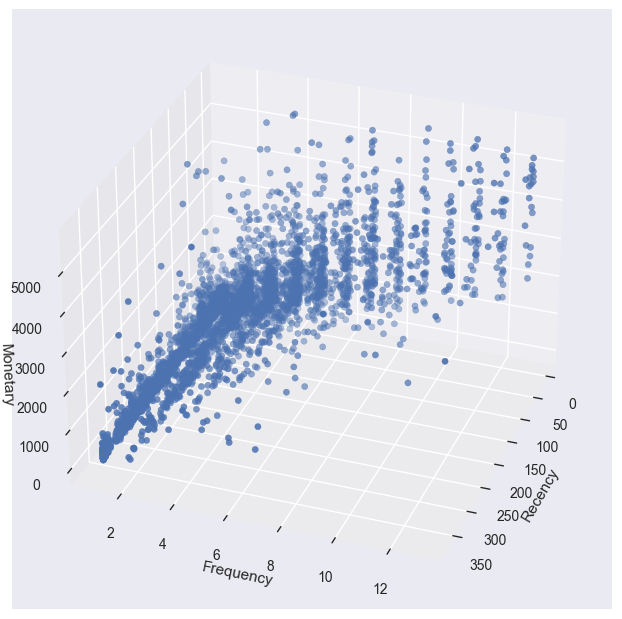

In [76]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['recency'].to_list(), 
    rfm_table_cleaned['frequency'].to_list(),
    rfm_table_cleaned['monetary_value'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

In [77]:
pipeline_pca = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('PCA', decomposition.PCA(n_components=2))
])
rfm_table_processed = pd.DataFrame(pipeline_pca.fit_transform(rfm_table_cleaned), columns=['axis-1', 'axis-2'])
pipeline_pca['PCA'].explained_variance_ratio_

array([0.67747053, 0.24012744])

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

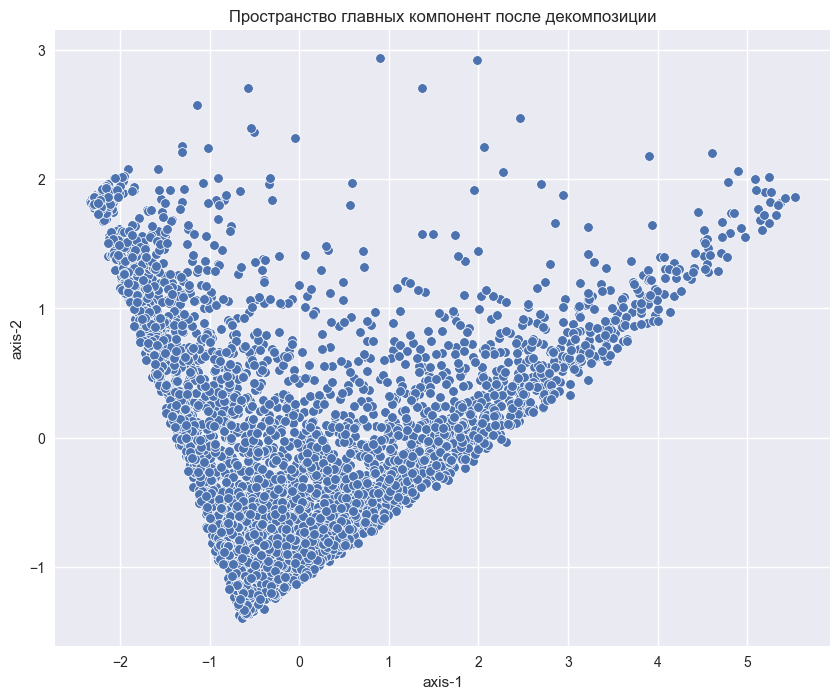

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', ax=ax)
ax.set_title('Пространство главных компонент после декомпозиции');

Попробуем разделить это пространство главных компонент на сегменты. 

**Примечание.** Судя по форме пространства, мы можем с уверенностью сказать, что нам не подойдут алгоритмы, основанные на плотности, такие как DBSCAN, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

Воспользуемся методом k-means. 

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

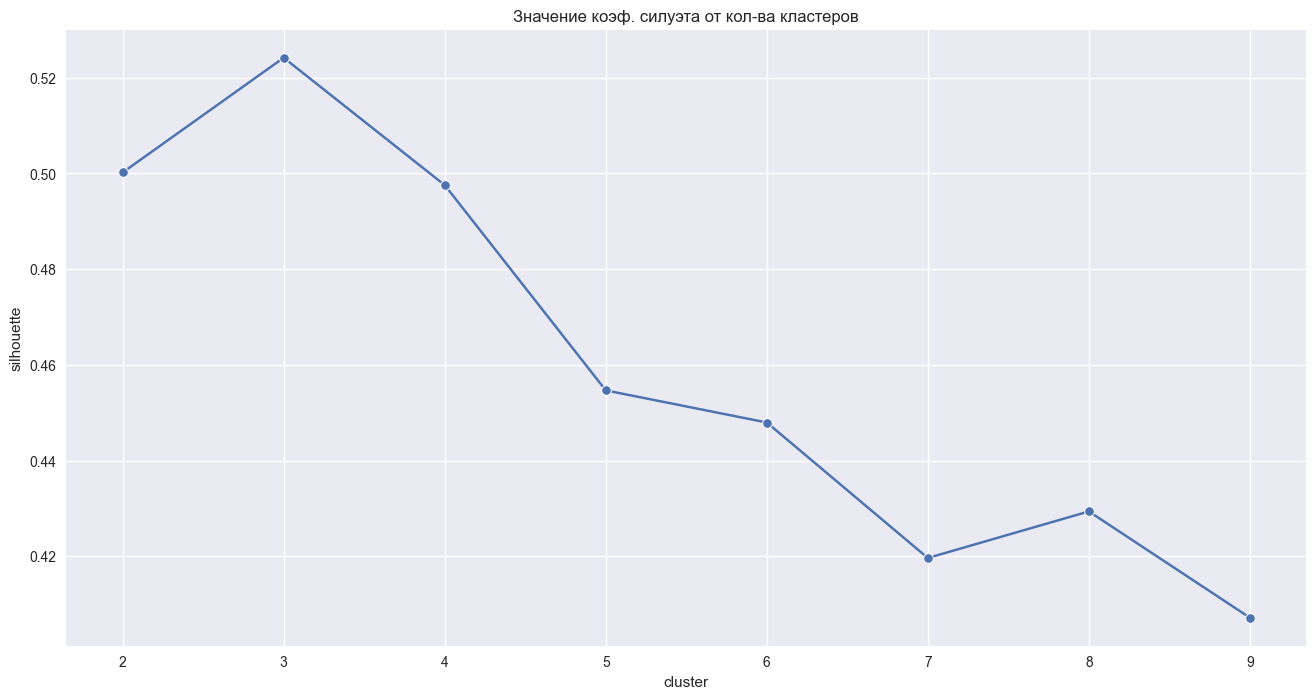

In [79]:
# напишем функцию, которая будет возвращать коэф. силуэта
def get_silhouette(X, estimator):
    estimator.fit(X)
    # подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    try:
        labels = estimator.labels_
    except AttributeError:
        labels = estimator.predict(X)
    silhouette = metrics.silhouette_score(X, labels)
    return silhouette

# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(rfm_table_processed, estimator=cluster.KMeans(n_clusters=cluster_num, random_state=42)))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid");
# визуализируем зависимость значения силуэта от количества кластеров
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o", ax=ax)
ax.set_title('Значение коэф. силуэта от кол-ва кластеров');

Теперь возьмём EM-алгоритм.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

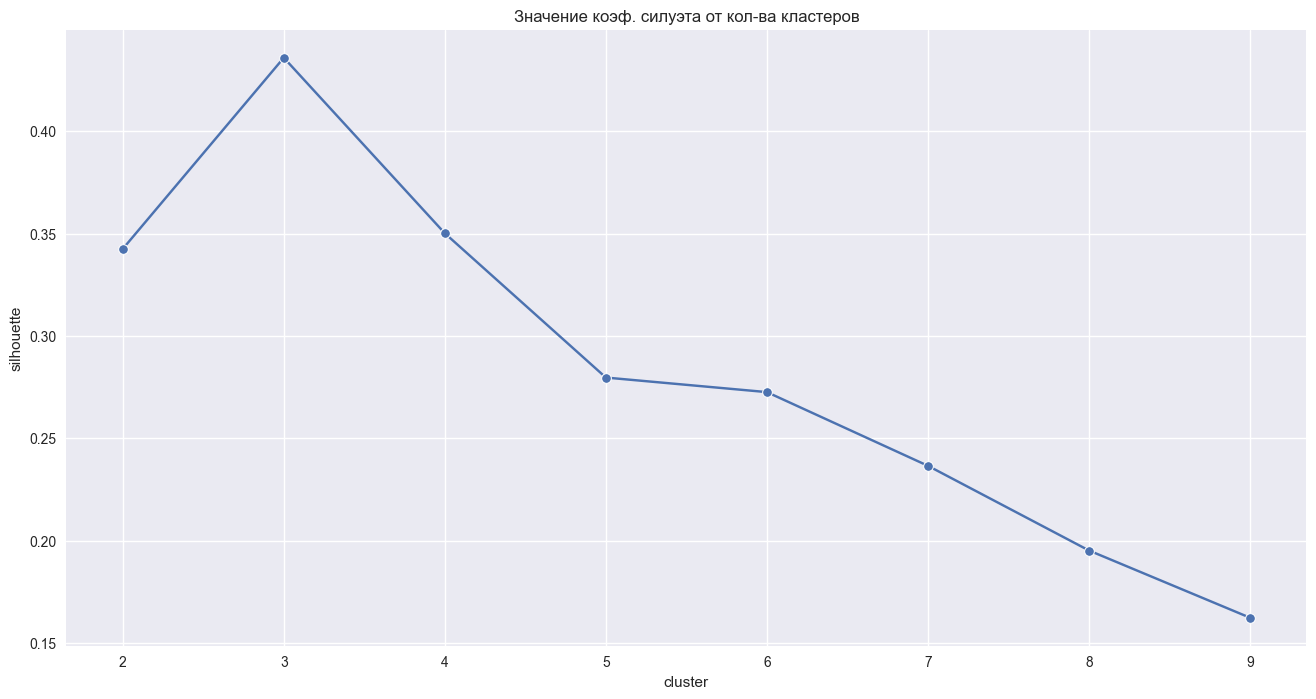

In [80]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(rfm_table_processed, estimator=mixture.GaussianMixture(n_components=cluster_num, random_state=42)))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid");
# визуализируем зависимость значения силуэта от количества кластеров
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o", ax=ax)
ax.set_title('Значение коэф. силуэта от кол-ва кластеров');

Давайте посмотрим на распределение кластеров.

Модель kmeans показала наибольший коэф. силуэта при оптимальном кол-ве кластеров, так что в дальнейшем будем использовать ее.

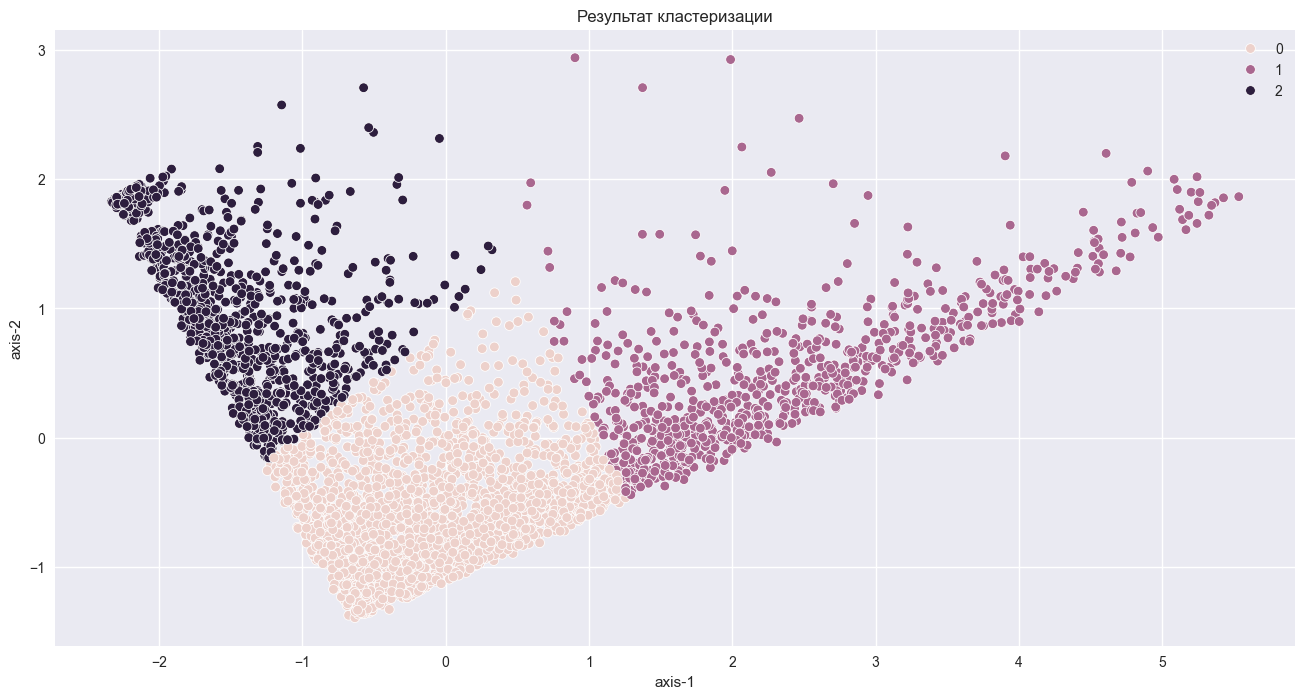

In [81]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_table_processed)
rfm_table_cleaned['kmeans_clusters'] = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(rfm_table_processed, x='axis-1', y='axis-2', hue=kmeans.labels_, ax=ax)
ax.set_title('Результат кластеризации');

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции я реализовал собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией я также добавили в реализацию функции plot_cluster_profile().

In [82]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    display(grouped_data)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [83]:
rfm_grouped = rfm_table_cleaned.groupby('kmeans_clusters').mean()
plot_cluster_profile(rfm_grouped, 3)

,recency,frequency,monetary_value
0,0.086673,0.16308,0.120455
1,0.000000,1.00000,1.000000
2,1.000000,0.00000,0.000000


### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [84]:
pipeline_tsne = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('TSNE', manifold.TSNE(n_components=2, perplexity=50, random_state=100))
])
rfm_table_processed = pd.DataFrame(pipeline_tsne.fit_transform(rfm_table_cleaned.drop('kmeans_clusters', axis=1)), columns=['axis-1', 'axis-2'])
pipeline_tsne['TSNE'].kl_divergence_

0.5415275692939758

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


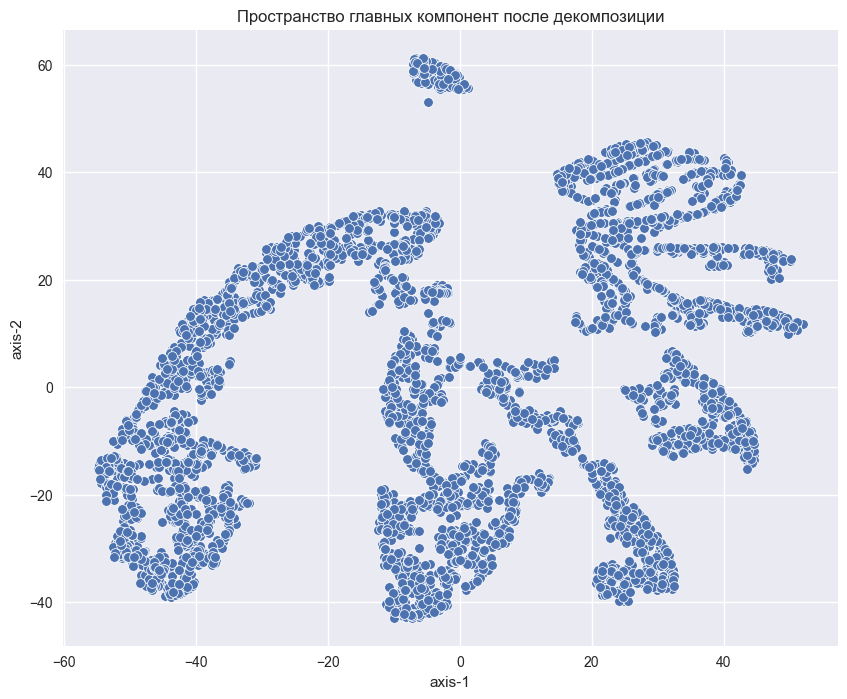

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', ax=ax)
ax.set_title('Пространство главных компонент после декомпозиции');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


Попробуем воспользоваться методом k-means. 

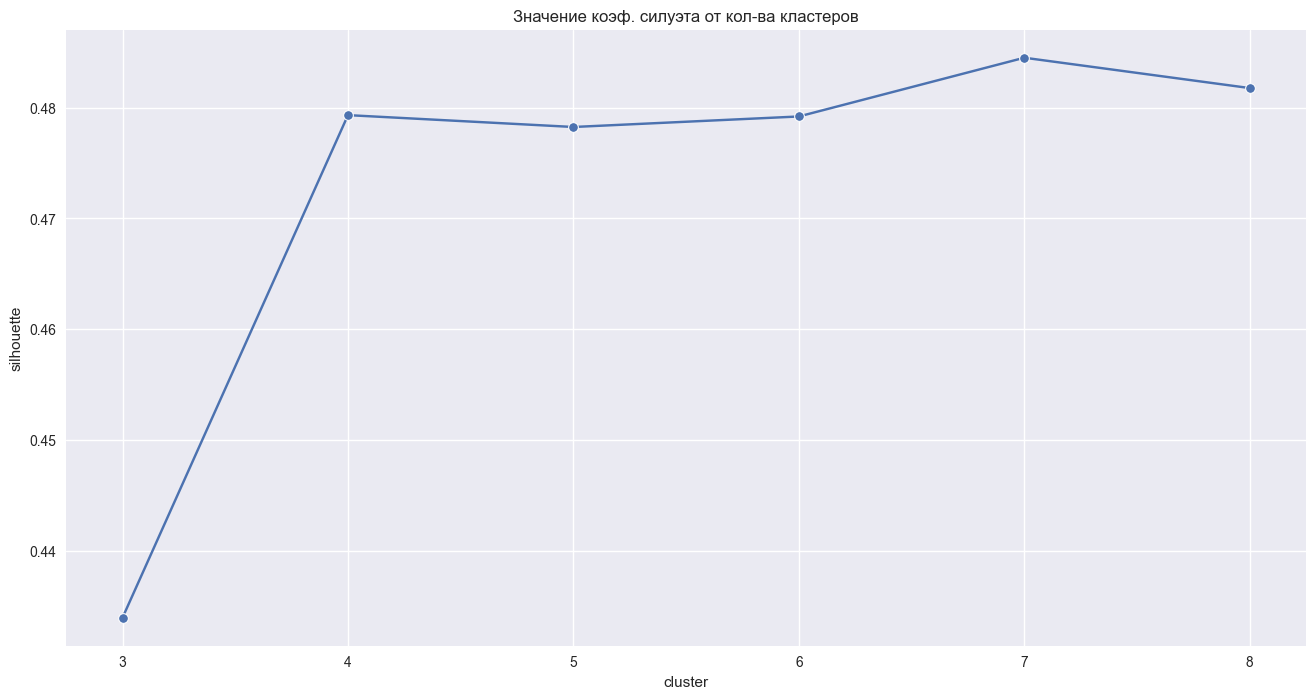

In [86]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(rfm_table_processed, estimator=cluster.KMeans(n_clusters=cluster_num, random_state=42)))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid");
# визуализируем зависимость значения силуэта от количества кластеров
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o", ax=ax)
ax.set_title('Значение коэф. силуэта от кол-ва кластеров');

Попробуем воспользоваться EM-алгоритом.

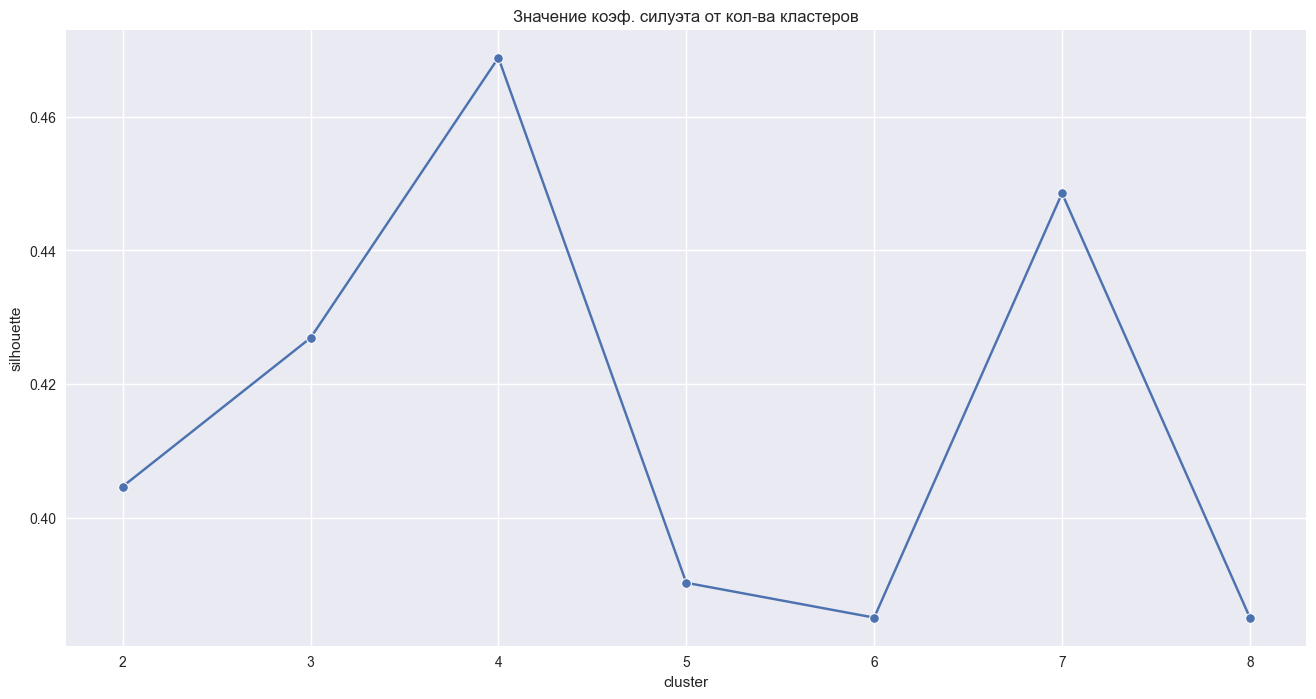

In [87]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette(rfm_table_processed, estimator=mixture.GaussianMixture(n_components=cluster_num, random_state=42)))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid");
# визуализируем зависимость значения силуэта от количества кластеров
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o", ax=ax)
ax.set_title('Значение коэф. силуэта от кол-ва кластеров');

Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

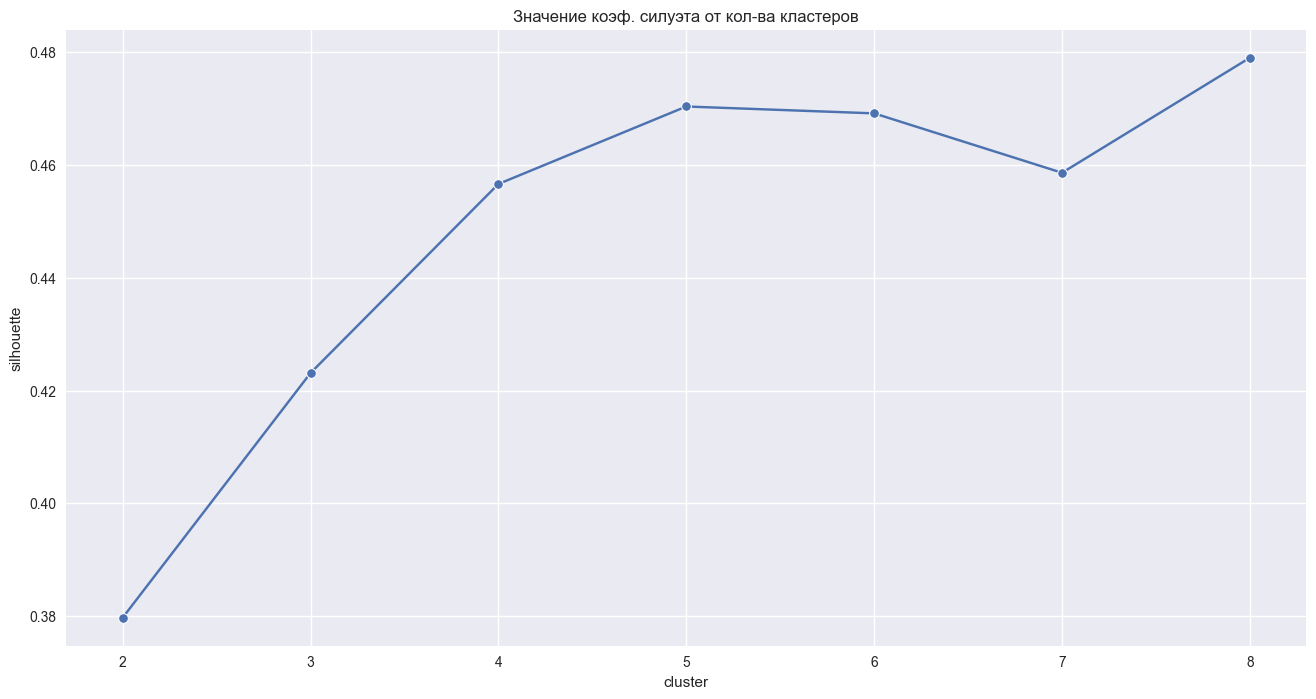

In [88]:
# создадим пустой словарь, ключами будут силуэт и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette(rfm_table_processed, estimator=cluster.AgglomerativeClustering(n_clusters=cluster_num)))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid");
# визуализируем зависимость значения силуэта от количества кластеров
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o", ax=ax)
ax.set_title('Значение коэф. силуэта от кол-ва кластеров');

Давайте посмотрим на распределение кластеров.

Сначала обучим модель, которая показала наилучший коэф. силуэта.

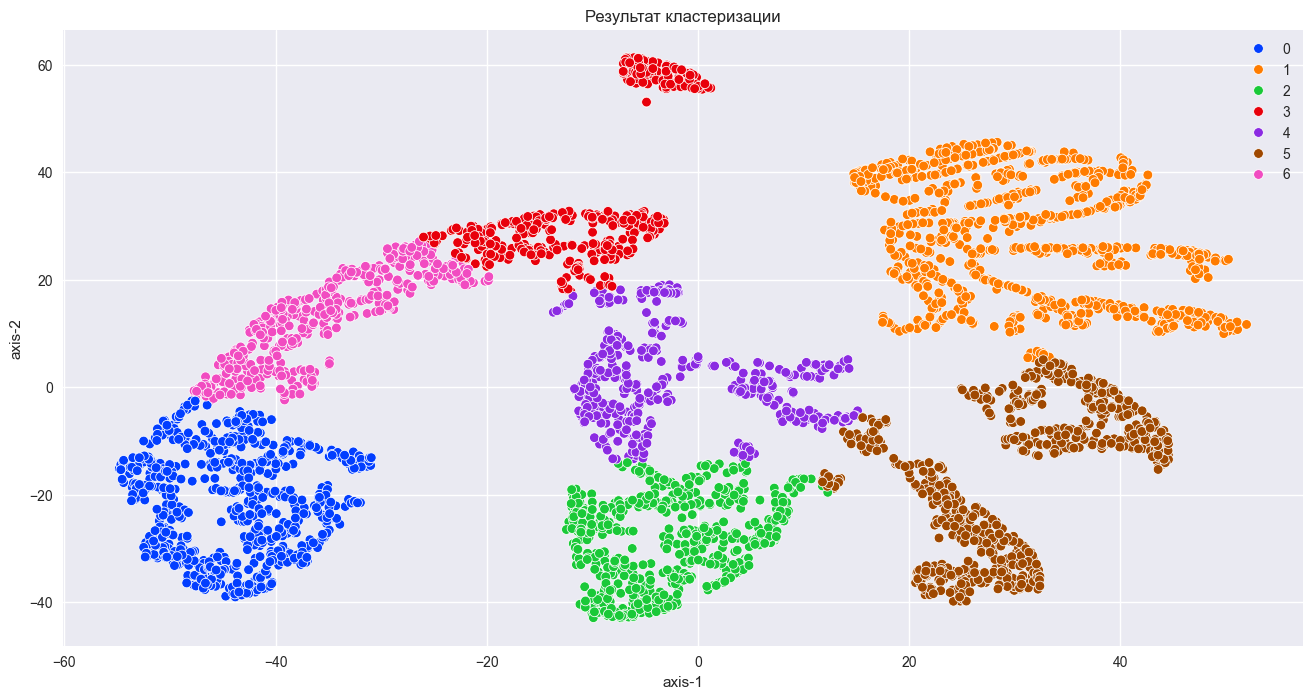

In [96]:
kmeans = cluster.KMeans(n_clusters=7, random_state=42)
kmeans.fit(rfm_table_processed)
rfm_table_cleaned['kmeans_clusters'] = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(rfm_table_processed, x='axis-1', y='axis-2', hue=kmeans.labels_, palette='bright', ax=ax)
ax.set_title('Результат кластеризации');


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируем кластеры и на основе анализа сопоставим номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [98]:
rfm_grouped = rfm_table_cleaned.groupby('kmeans_clusters').mean()
plot_cluster_profile(rfm_grouped, 7)

,recency,frequency,monetary_value
0,0.049640,0.000000,0.028037
1,0.000000,1.000000,1.000000
2,0.027162,0.169792,0.163564
3,1.000000,0.002183,0.000000
4,0.582325,0.249852,0.189848
5,0.027616,0.424757,0.340571
6,0.531145,0.000000,0.005734


## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

Разделяем исходные данные на тестовые и тренировочные.

In [99]:
X = rfm_table_cleaned.drop('kmeans_clusters', axis=1)
y = rfm_table_cleaned['kmeans_clusters']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (3235, 3)
Test shape: (809, 3)


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 

Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5.

In [101]:
rf_model = ensemble.RandomForestClassifier(random_state=42)
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
rf_grid = model_selection.GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f'Best params: {rf_grid.best_params_}')

y_train_pred = rf_grid.predict(X_train)
print(f'Accuracy train: {metrics.accuracy_score(y_train, y_train_pred)}')
y_test_pred = rf_grid.predict(X_test)
print(f'Accuracy train: {metrics.accuracy_score(y_test, y_test_pred)}')

Best params: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}
Accuracy train: 1.0
Accuracy train: 0.9851668726823238


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5. 

In [103]:
gb_model = ensemble.GradientBoostingClassifier(random_state=42)
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
gb_grid = model_selection.GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)
print(f'Best params: {gb_grid.best_params_}')

y_train_pred = gb_grid.predict(X_train)
print(f'Accuracy train: {metrics.accuracy_score(y_train, y_train_pred)}')
y_test_pred = gb_grid.predict(X_test)
print(f'Accuracy train: {metrics.accuracy_score(y_test, y_test_pred)}')

Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Accuracy train: 1.0
Accuracy train: 0.9826946847960445


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.